# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False).transpose()
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail(3))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False).transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail(3))


'cases'

Country/Region,US,India,France,Germany,Brazil,Japan,"Korea, South",Italy,United Kingdom,Russia,...,Nauru,Kiribati,Tuvalu,Summer Olympics 2020,Diamond Princess,Winter Olympics 2022,Holy See,Antarctica,MS Zaandam,"Korea, North"
2023-03-07,103690910,44689919,39854299,38231610,37076053,33298799,30594297,25603510,24629846,22051220,...,5247,5013,2805,865,712,535,29,11,9,1
2023-03-08,103755771,44690298,39860410,38241231,37076053,33310604,30605187,25603510,24629922,22063473,...,5247,5014,2805,865,712,535,29,11,9,1
2023-03-09,103802702,44690738,39866718,38249060,37076053,33320438,30615522,25603510,24658705,22075858,...,5247,5014,2805,865,712,535,29,11,9,1


'deaths'

Country/Region,US,Brazil,India,Russia,Mexico,United Kingdom,Peru,Italy,Germany,France,...,Tonga,Palau,"Korea, North",MS Zaandam,Nauru,Summer Olympics 2020,Winter Olympics 2022,Antarctica,Tuvalu,Holy See
2023-03-07,1122516,699276,530775,388396,333136,220721,219513,188322,168709,166138,...,13,9,6,2,1,0,0,0,0,0
2023-03-08,1123246,699276,530776,388440,333170,220721,219539,188322,168808,166165,...,13,9,6,2,1,0,0,0,0,0
2023-03-09,1123836,699276,530779,388478,333188,220721,219539,188322,168935,166176,...,13,9,6,2,1,0,0,0,0,0


## Add Trailing Avg Changes 3-day 7-day 14day

In [30]:
df_rolls = dfc_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(columns={df_rolls.columns[0]:'Cases3dayAvg'})
df_rolls['Cases7dayAvg'] = dfc_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Cases14dayAvg'] = dfc_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls['Deaths3dayAvg'] = dfd_g.diff().rolling(3).mean().transpose().iloc[:,-1:]
df_rolls['Deaths7dayAvg'] = dfd_g.diff().rolling(7).mean().transpose().iloc[:,-1:]
df_rolls['Deaths14dayAvg'] = dfd_g.diff().rolling(14).mean().transpose().iloc[:,-1:]
df_rolls = df_rolls.rename(index={'US':'United States'})
df_rolls.head()


,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
Country/Region,,,,,,
United States,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
India,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429
France,6494.000000,4403.142857,4052.642857,20.666667,18.000000,20.500000
Germany,12736.333333,6641.285714,11355.071429,179.333333,91.285714,86.571429
Brazil,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429


## Add Global Population by Country

In [31]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'RUS','Country Name'] = 'Russia'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'IRN','Country Name'] = 'Iran'
df_gpop_2016.loc[df_gpop_2016['Country Code'] == 'COD','Country Name'] = 'Congo'
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})
display(df_gpop_2016[df_gpop_2016['Country/Region'].isin(['Italy','Russian Federation','Russia'])])

df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })

# merge rolling averages
df_gmerged = pd.merge(left=df_gmerged, right=df_rolls, on='Country/Region')

display(df_gmerged.sort_values(by=['Population'], ascending=False).head(10))  
display(dfc_g.iloc[0:1,:].count(axis=1), df_gmerged['Country/Region'].count())  # join check 185 in -> 159 out ?


,Country/Region,Country Code,Year,Value
8427,Italy,ITA,2016,60627498
12259,Russia,RUS,2016,144342396


,Country/Region,Deaths,Cases,Country Code,Year,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg
19,China,101056,4903524,CHN,2016,1378665000,0.000000,0.000000,0.071429,0.333333,0.714286,1.428571
2,India,530779,44690738,IND,2016,1324509589,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429
0,United States,1123836,103802702,USA,2016,322941311,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286
10,Indonesia,160941,6738225,IDN,2016,261554226,307.333333,235.571429,228.000000,3.000000,3.000000,3.142857
1,Brazil,699276,37076053,BRA,2016,206163058,0.000000,1798.428571,4793.500000,0.000000,11.285714,31.571429
33,Pakistan,30644,1577411,PAK,2016,203627284,56.000000,48.428571,44.000000,0.333333,0.142857,0.214286
93,Nigeria,3155,266598,NGA,2016,185960289,0.000000,0.000000,9.642857,0.000000,0.000000,0.000000
34,Bangladesh,29445,2037871,BGD,2016,157970840,14.000000,6.000000,7.000000,0.000000,0.000000,0.000000
3,Russia,388478,22075858,RUS,2016,144342396,11661.000000,12535.428571,12031.571429,41.000000,39.571429,36.357143
20,Japan,72997,33320438,JPN,2016,126994511,11268.333333,9678.857143,10506.214286,61.333333,59.428571,67.000000


2020-01-22    201
dtype: int64

173

## Add Various Other Data from WorldBank.Org

In [32]:
# all available indicators https://data.worldbank.org/indicator
#    API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#    I should bundle into a single request XLS or Json results, but alas.. this works for now
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def get_zip(url):
    urllib.request.urlretrieve(url, "X.zip")
    compressed_file = zipfile.ZipFile('X.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [33]:
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
#df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False) # 0 data for g10's
#df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False) # 0 data for g10's
df_gmerged3 = add_metric('IS.SHP.GOOD.TU', 'shipping', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.LE00.IN', 'lifeExpYrs', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FP.CPI.TOTL.ZG', 'inflation', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.DYN.TFRT.IN', 'fertility', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)

df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])
df_gmerged3.head()

In [ ]:
df_gmerged3.head(10).transpose()

,0,2,9,8,1,20,7,5,3,18
Country/Region,United States,India,France,Germany,Brazil,Japan,Italy,United Kingdom,Russia,Turkey
Deaths,1123836,530779,166176,168935,699276,72997,188322,220721,388478,101492
Cases,103802702,44690738,39866718,38249060,37076053,33320438,25603510,24658705,22075858,17042722
Country Code,USA,IND,FRA,DEU,BRA,JPN,ITA,GBR,RUS,TUR
Population,322941311,1324509589,66721256,82348669,206163058,126994511,60627498,65611593,144342396,79821724
Cases3dayAvg,49054.333333,381.666667,6494.0,12736.333333,0.0,11268.333333,0.0,9621.666667,11661.0,0.0
Cases7dayAvg,30420.714286,335.714286,4403.142857,6641.285714,1798.428571,9678.857143,3808.285714,4125.0,12535.428571,0.0
Cases14dayAvg,31227.928571,278.285714,4052.642857,11355.071429,4793.5,10506.214286,4006.857143,3952.5,12031.571429,0.0
Deaths3dayAvg,551.666667,1.333333,20.666667,179.333333,0.0,61.333333,0.0,0.0,41.0,0.0
Deaths7dayAvg,311.142857,1.0,18.0,91.285714,11.285714,59.428571,32.571429,0.0,39.571429,0.0


# Correlation Matrix

C:\Users\Hp\AppData\Local\Temp\ipykernel_7680\852356055.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_gmerged3.corr()
C:\Users\Hp\AppData\Local\Temp\ipykernel_7680\852356055.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
C:\Users\Hp\AppData\Local\Temp\ipykernel_7680\852356055.py:9: DeprecationWarning: `np.bool` is a deprecated alias for

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.893509,0.451527,0.748355,0.774303,0.784969,0.719027,0.755682,0.776704,0.752291,...,-0.041020,0.152861,0.259775,0.136947,-0.021579,-0.193149,-0.147192,0.040492,0.171467,-0.144074
Cases,0.893509,1.000000,0.400595,0.845804,0.854768,0.875761,0.803499,0.842307,0.857954,0.777750,...,-0.029106,0.273660,0.266582,0.191859,-0.037317,-0.219981,-0.178273,0.095069,0.301158,-0.111507
Population,0.451527,0.400595,1.000000,0.158898,0.167571,0.169706,0.151739,0.162491,0.168370,0.511306,...,-0.015707,-0.037343,0.738710,0.049131,-0.002224,-0.064669,-0.016791,0.038195,0.011127,-0.149834
Cases3dayAvg,0.748355,0.845804,0.158898,1.000000,0.974087,0.967743,0.952805,0.959691,0.953634,0.835555,...,-0.015415,0.272512,0.220418,0.131412,-0.030220,-0.152805,-0.141455,0.077173,0.247612,-0.068720
Cases7dayAvg,0.774303,0.854768,0.167571,0.974087,1.000000,0.988964,0.905064,0.940425,0.939145,0.804805,...,-0.022868,0.273621,0.214159,0.143436,-0.033319,-0.172377,-0.155707,0.082494,0.276015,-0.087308
Cases14dayAvg,0.784969,0.875761,0.169706,0.967743,0.988964,1.000000,0.914429,0.946744,0.949260,0.792938,...,-0.019959,0.280844,0.219232,0.147644,-0.034539,-0.175801,-0.156166,0.074220,0.283849,-0.087395
Deaths3dayAvg,0.719027,0.803499,0.151739,0.952805,0.905064,0.914429,1.000000,0.988425,0.980662,0.851641,...,-0.022551,0.226283,0.217836,0.099632,-0.021103,-0.112487,-0.109932,0.056087,0.185764,-0.078463
Deaths7dayAvg,0.755682,0.842307,0.162491,0.959691,0.940425,0.946744,0.988425,1.000000,0.997150,0.854540,...,-0.025503,0.238557,0.225794,0.117828,-0.024727,-0.134661,-0.125061,0.064046,0.221635,-0.092912
Deaths14dayAvg,0.776704,0.857954,0.168370,0.953634,0.939145,0.949260,0.980662,0.997150,1.000000,0.856805,...,-0.026695,0.242859,0.230541,0.123863,-0.026554,-0.140160,-0.127585,0.060794,0.229043,-0.100564
flights,0.752291,0.777750,0.511306,0.835555,0.804805,0.792938,0.851641,0.854540,0.856805,1.000000,...,-0.025244,0.248361,0.617921,0.140969,-0.033440,-0.162663,-0.144508,0.094186,0.176653,-0.103940


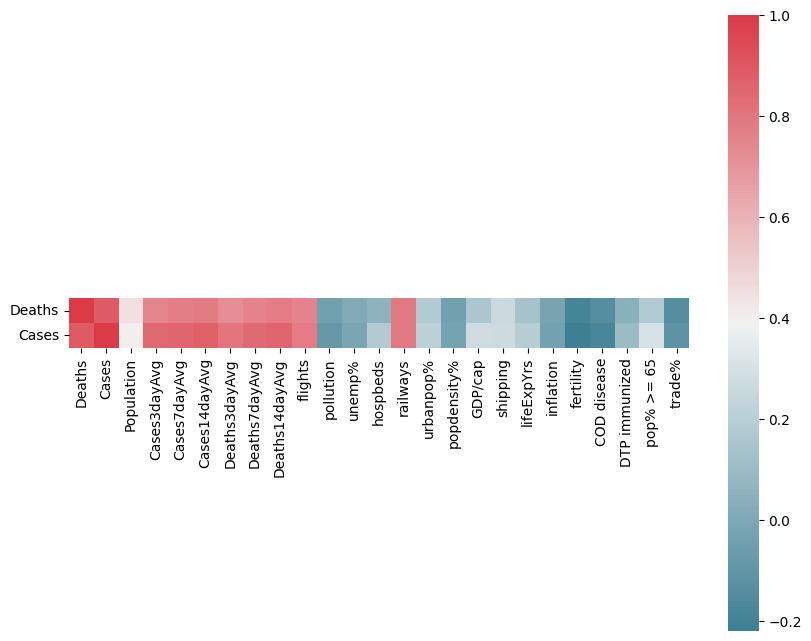

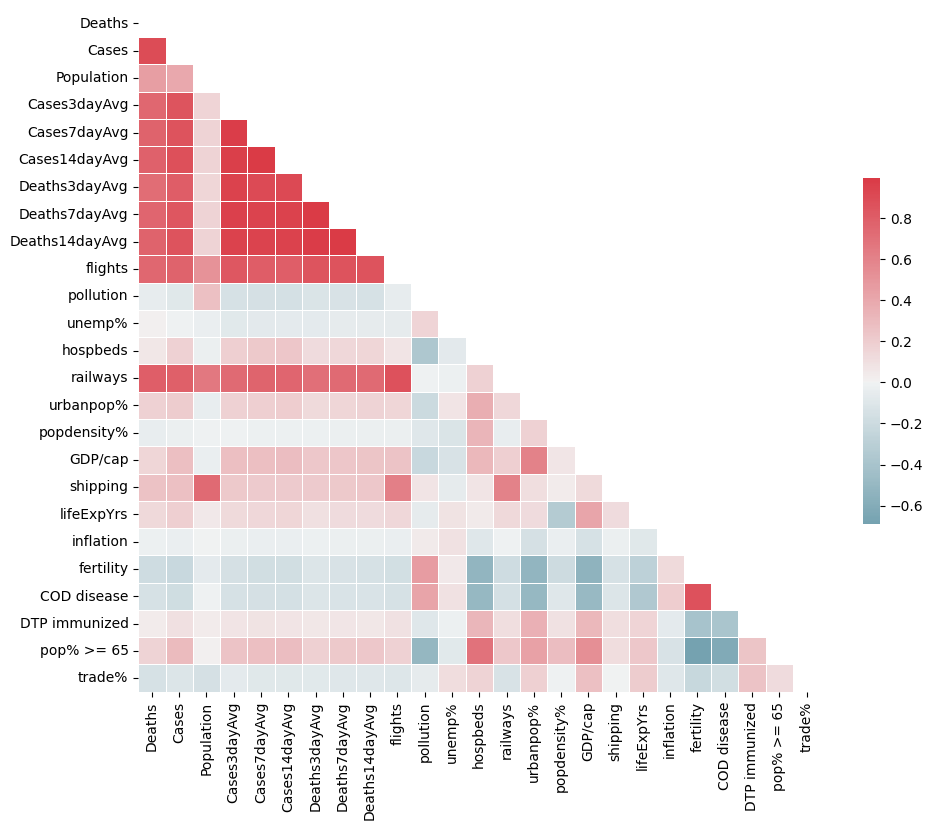

In [ ]:
import seaborn as sns

df_corr = df_gmerged3.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_orig = df_gmerged3.copy().set_index('Country/Region').drop(columns=['Country Code'])
df_sc = pd.DataFrame(scaler.fit_transform(df_orig), index=df_orig.index, columns=df_orig.columns)

display('original',df_orig.head(2),'scaled',df_sc.head(2))

'original'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,1123836,103802702,322941311,49054.333333,30420.714286,31227.928571,551.666667,311.142857,308.214286,10099031.0,...,35.89,65094.80,55518878.0,78.79,1.81,1.71,5.30,94.0,15.79,19.69
India,530779,44690738,1324509589,381.666667,335.714286,278.285714,1.333333,1.000000,1.071429,1209803.0,...,465.19,6887.54,17053200.0,70.91,3.73,2.11,24.17,91.0,6.47,28.62


'scaled'

,Deaths,Cases,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,Deaths14dayAvg,flights,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,,,,
United States,9.160150,9.451326,1.893412,11.607132,10.959878,10.653069,12.265015,12.112501,12.054909,11.286728,...,-0.186442,1.992616,2.653764,0.596965,-0.169078,-0.676943,-0.737306,0.408180,0.971276,-1.099017
India,4.153656,3.874744,8.601929,-0.115429,-0.106558,-0.136903,-0.126815,-0.144374,-0.149425,1.130794,...,0.096931,-0.642888,0.662940,0.003461,-0.077701,-0.377042,0.240800,0.219538,-0.398460,-0.857775


# Misc Clustering Techniques

## - Basic Template for KMeans

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

df_train = df_sc.copy()

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'kmeans info - inertia: {kmeans.inertia_}, iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels

def fl_col(df, f=3, l=9):  # print first 3 and last 2 cols together
    return pd.concat([df.iloc[:,0:f],df.iloc[:,-l:]], axis=1)
    
df_train.insert(0, 'cluster', kmeans.labels_)
display('train', fl_col(pd.concat([df_train.head(5),
                            df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])]])))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count())


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


'kmeans info - inertia: 2542.837385394423, iters: 6'

'labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0\n 0 0 2 0 0 0 2 0 2 0 2 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 2 0\n 2 0 0 0 0 0 0 2 2 0 2 0 0 0 0 2 2 0 2 0 0 0 2 2 2 2 2 2 2 0 0 0 0 2 2 2 0\n 2 2 2 0 0 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2 2\n 0 2 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2 2 2 2 2 0 0 2 0]'

'train'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,1,9.160150,9.451326,1.992616,2.653764,0.596965,-0.169078,-0.676943,-0.737306,0.408180,0.971276,-1.099017
India,0,4.153656,3.874744,-0.642888,0.662940,0.003461,-0.077701,-0.377042,0.240800,0.219538,-0.398460,-0.857775
France,0,1.075735,3.419649,1.331827,0.084201,0.901248,-0.202392,-0.564480,-0.681844,0.533941,1.689947,-0.417705
Germany,0,1.099026,3.267041,1.644152,0.794567,0.785259,-0.186211,-0.804401,-0.765296,0.219538,1.844263,0.261175
Brazil,0,5.576081,3.156380,-0.261767,0.319294,0.337119,-0.077701,-0.684440,-0.301383,-1.100959,-0.026633,-1.033371
United States,1,9.160150,9.451326,1.992616,2.653764,0.596965,-0.169078,-0.676943,-0.737306,0.408180,0.971276,-1.099017
India,0,4.153656,3.874744,-0.642888,0.662940,0.003461,-0.077701,-0.377042,0.240800,0.219538,-0.398460,-0.857775
Japan,0,0.289133,2.802078,0.960930,0.933287,1.016485,-0.232851,-0.939356,-0.478136,0.659703,2.953867,-0.878847
Italy,0,1.262688,2.074068,1.118951,0.304107,0.951711,-0.226188,-1.006833,-0.726939,0.533941,2.039730,-0.270745


,Cases
cluster,
0,98
1,1
2,74


## - Basic Template for DBSCAN

I saw a presentation by Healy & McInnes on Youtube that basically said KMeans sucks, and we should use DBScan or their upgraded version HDBScan.   https://www.youtube.com/watch?v=ayZQj4llUSU&t=1824s


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

df_train = df_sc.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_train)
components = clustering.components_
labels =clustering.labels_
core_sample_indices = clustering.core_sample_indices_
display(f'model: {clustering}')

display(f'core_sample_indices_[0:10]: {core_sample_indices[0:10]}')
display(f'components_[0]: {components[0]}')    
display(f'labels/fit_predict[0:10]: {labels[0:10]}')                       

df_train.insert(0, 'cluster',clustering.labels_)
display('train2',pd.concat([fl_col(df_train).head(), 
                            fl_col(df_train[df_train.index.isin(['China','Japan','United States','Italy','Spain','India','Poland'])])]))
display(df_train[['cluster','Cases']].groupby(by=['cluster']).count().rename(columns={'Cases':'Count'}))


'model: DBSCAN(eps=3, min_samples=2)'

'core_sample_indices_[0:10]: [ 2  6  7  9 10 11 12 13 14 15]'

'components_[0]: [ 1.07573524  3.41964926  0.1772472   1.35669526  1.38960065  1.17895066\n  0.30851263  0.5274676   0.62257033  0.43223652 -0.74414763  0.32803064\n  1.3411923   1.35541112  0.8933668  -0.12889617  1.33182737  0.08420122\n  0.90124841 -0.20239245 -0.56448027 -0.68184361  0.53394147  1.68994735\n -0.41770537]'

'labels/fit_predict[0:10]: [-1 -1  0 -1 -1 -1  0  0 -1  0]'

'train2'

,cluster,Deaths,Cases,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,
United States,-1,9.160150,9.451326,1.992616,2.653764,0.596965,-0.169078,-0.676943,-0.737306,0.408180,0.971276,-1.099017
India,-1,4.153656,3.874744,-0.642888,0.662940,0.003461,-0.077701,-0.377042,0.240800,0.219538,-0.398460,-0.857775
France,0,1.075735,3.419649,1.331827,0.084201,0.901248,-0.202392,-0.564480,-0.681844,0.533941,1.689947,-0.417705
Germany,-1,1.099026,3.267041,1.644152,0.794567,0.785259,-0.186211,-0.804401,-0.765296,0.219538,1.844263,0.261175
Brazil,-1,5.576081,3.156380,-0.261767,0.319294,0.337119,-0.077701,-0.684440,-0.301383,-1.100959,-0.026633,-1.033371
United States,-1,9.160150,9.451326,1.992616,2.653764,0.596965,-0.169078,-0.676943,-0.737306,0.408180,0.971276,-1.099017
India,-1,4.153656,3.874744,-0.642888,0.662940,0.003461,-0.077701,-0.377042,0.240800,0.219538,-0.398460,-0.857775
Japan,-1,0.289133,2.802078,0.960930,0.933287,1.016485,-0.232851,-0.939356,-0.478136,0.659703,2.953867,-0.878847
Italy,0,1.262688,2.074068,1.118951,0.304107,0.951711,-0.226188,-1.006833,-0.726939,0.533941,2.039730,-0.270745


,Count
cluster,
-1,14
0,155
1,2
2,2


---

# Dimension Reduction

## - PCA Method

Most research tells us due to "Curse of Dimensionality" that you need to reduce dims before you run clustering.  Hence we redo.

[Text(0, 0.5, 'PCA3')]

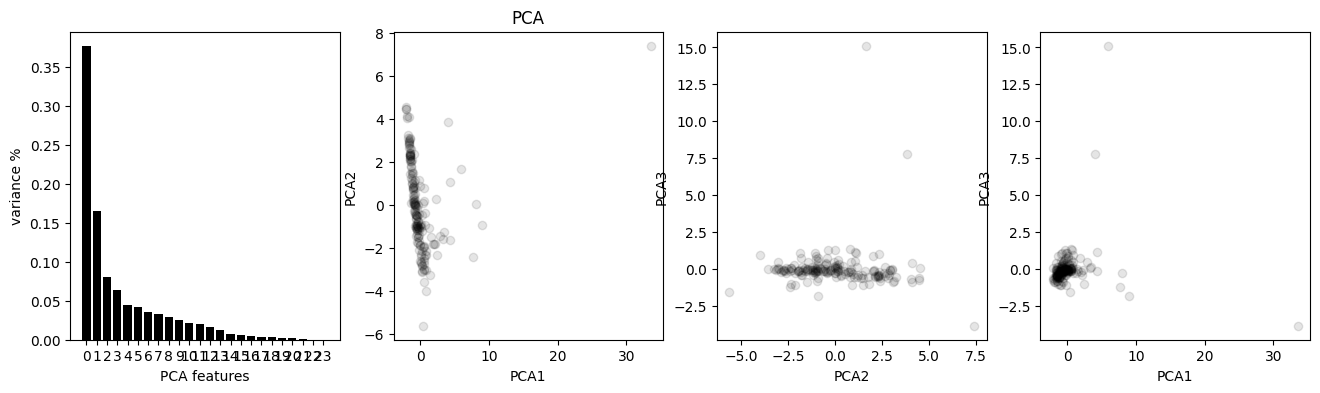

In [ ]:
# method copied from kaggle: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

plotX = df_sc.copy()

pca = PCA(n_components='mle')
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents, index=plotX.index)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,4, figsize=(16,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
ax[1].set(xlabel = 'PCA1')
ax[1].set(ylabel = 'PCA2')
ax[1].set(title='PCA')

ax[2].scatter(PCA_components[1], PCA_components[2], alpha=.1, color='black')
ax[2].set(xlabel = 'PCA2')
ax[2].set(ylabel = 'PCA3')

ax[3].scatter(PCA_components[0], PCA_components[2], alpha=.1, color='black')
ax[3].set(xlabel = 'PCA1')
ax[3].set(ylabel = 'PCA3')



## 

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

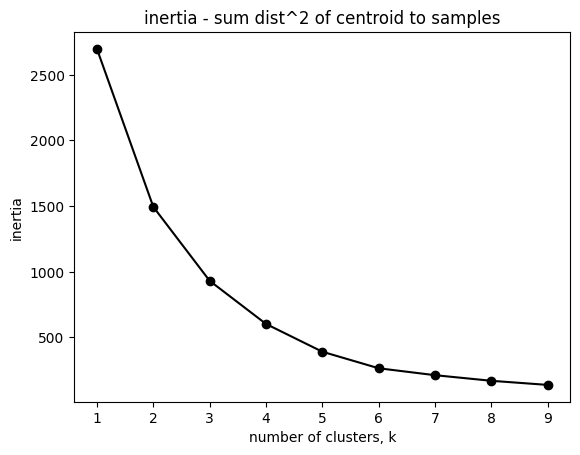

In [ ]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

## KMeans Cluster Variants and Plots

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

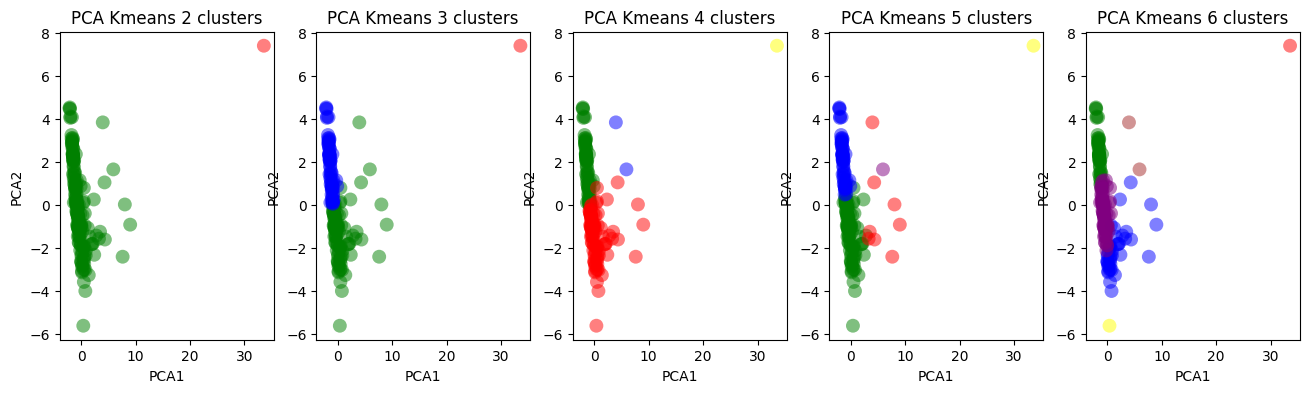

In [ ]:
cluster_cases = [2,3,4,5,6]

def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
#        m = model.fit(df_comp2.iloc[:,:dims])
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

# hmm which one to pick?
plot_clusters('PCA', cluster_cases, PCA_components)



## KMeans with Point Labels

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


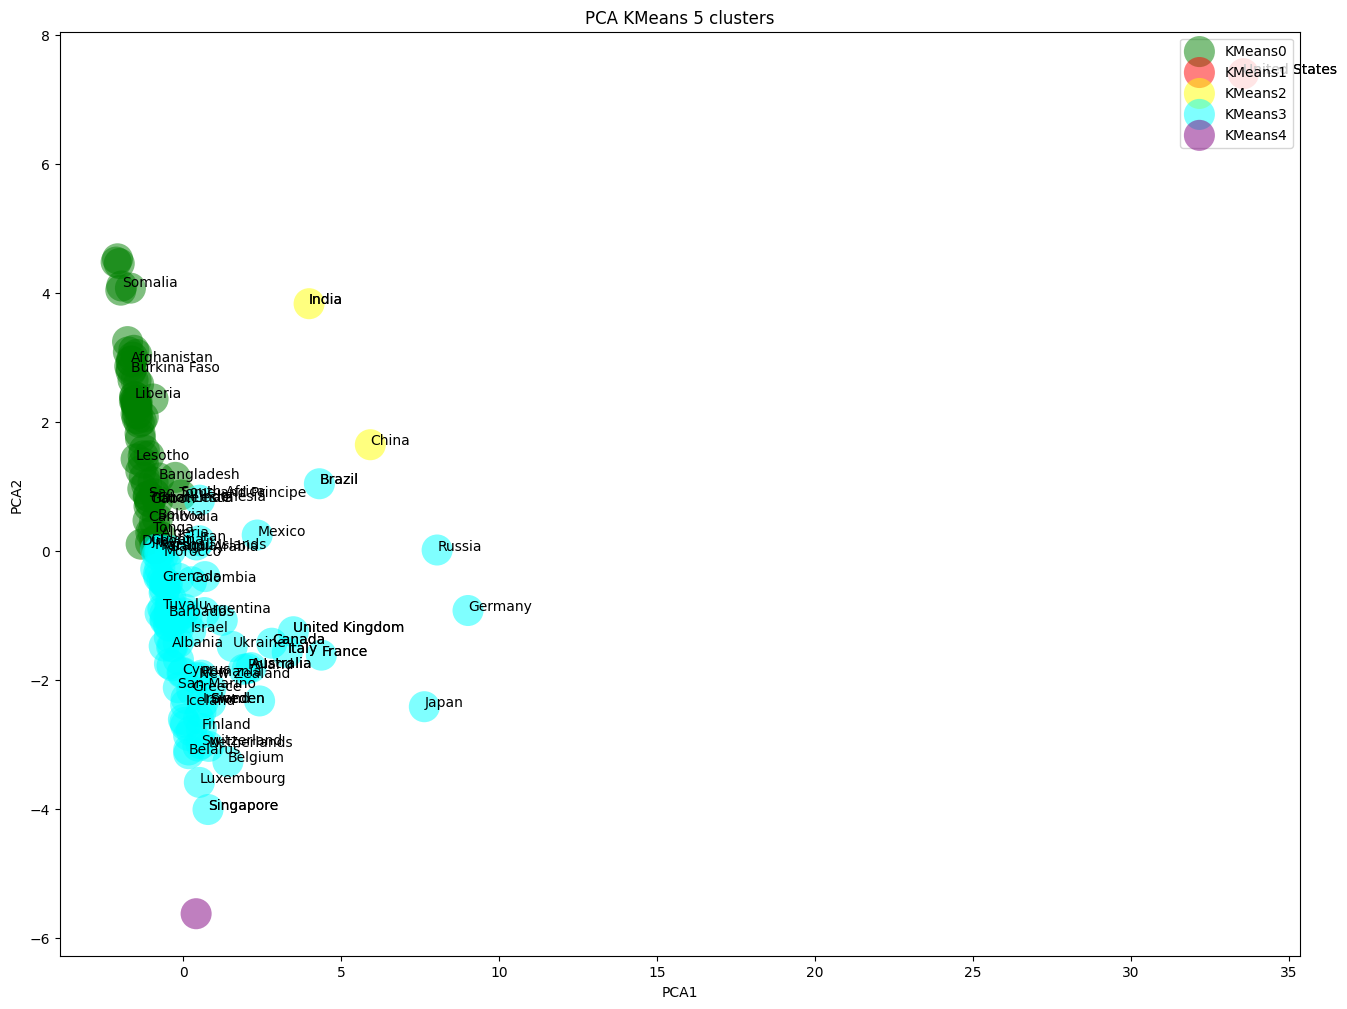

In [ ]:
def plot_big(clustering_name, reducer_name, model, df_comp, dims=2, countries=30):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2)  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(dims):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)

    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(f'{reducer_name} {clustering_name} {len(set(m.labels_))} clusters')
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')

    for index,row in df_comp2[df_comp2.index.isin(['United Kingdom','Belgium','Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Sweden', 'Switzerland','Canada','Japan','United States','China','Australia','Singapore','South Africa','Belarus','Brazil','Russia','India','Poland'])].iterrows():
        ax.annotate(index, (row[0],row[1]))
    for index,row in df_comp2.sample(countries).iterrows():
        ax.annotate(index, (row[0],row[1]))

    plt.legend(loc=1)
    plt.show()
    
# zoom on n cluster solution
clusters=5
model = KMeans(n_clusters=clusters)
plot_big('KMeans','PCA',model, PCA_components, countries=50)


## -T-SNE Method (T-Distributed Stochastic Neighbor Embedding)

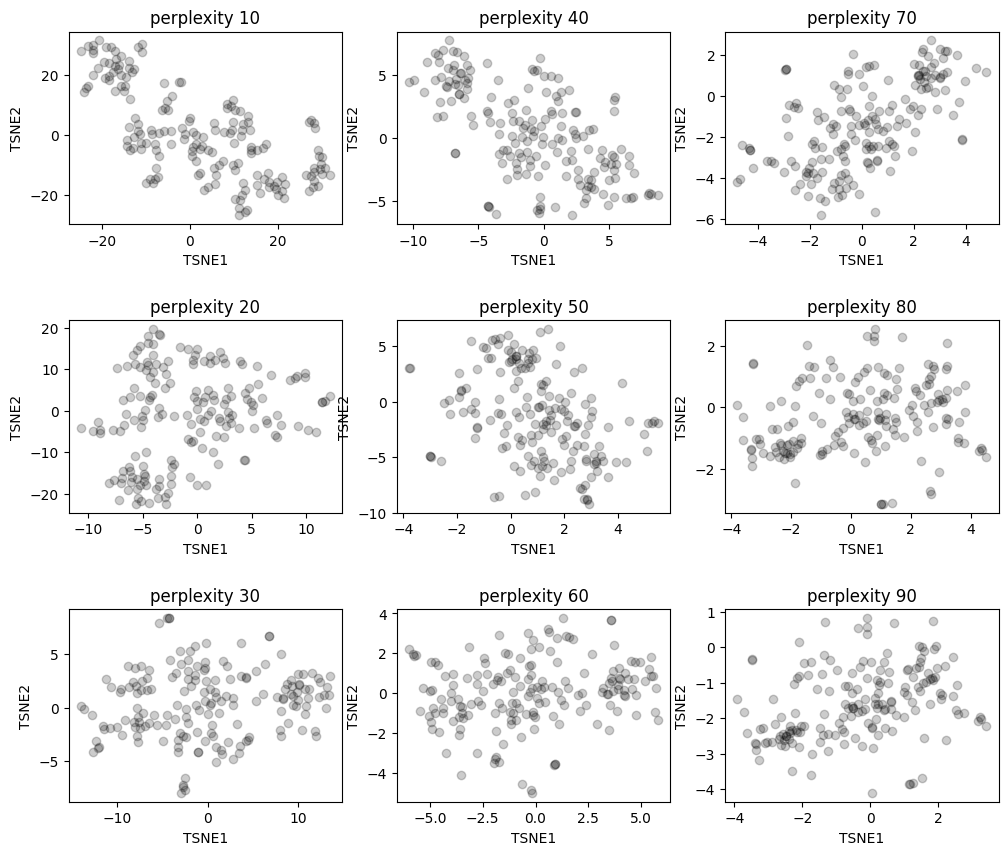

In [ ]:
plotX = df_train.copy()
ps = [10,20,30,40,50,60,70,80,90]

fig,ax = plt.subplots(3, 3, figsize=(12,10))
plt.subplots_adjust(hspace=.5)
import math 

# the search for ideal perplexity hyperameters...
for i, perplexity in enumerate(ps):
    tsne = TSNE(n_components=2, perplexity=perplexity)
    tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
    TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)

    ax[i%3][math.floor(i/3)].set_title(f'perplexity {perplexity}')
    ax[i%3][math.floor(i/3)].scatter(TSNE_components[0], TSNE_components[1], alpha=.2, color='black')
    ax[i%3][math.floor(i/3)].set(xlabel = 'TSNE1')
    ax[i%3][math.floor(i/3)].set(ylabel = 'TSNE2')


## Fixing TSNE HyperParams (Perplexity and Comps)

In [ ]:
# pick perp 30 randomly, comps 2 or 3 (plot dimensions I think)
tsne = TSNE(n_components=2, perplexity=30)
tsneComponents = tsne.fit_transform(plotX.drop(["cluster"], axis=1))
TSNE_components = pd.DataFrame(tsneComponents, index=plotX.index)
TSNE_components.head()

,0,1
Country/Region,,
United States,-9.009520,4.739373
India,3.753762,5.273480
France,-6.261081,4.833048
Germany,-8.344407,5.063232
Brazil,2.985550,5.446514


## KMeans w/ TSNE

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

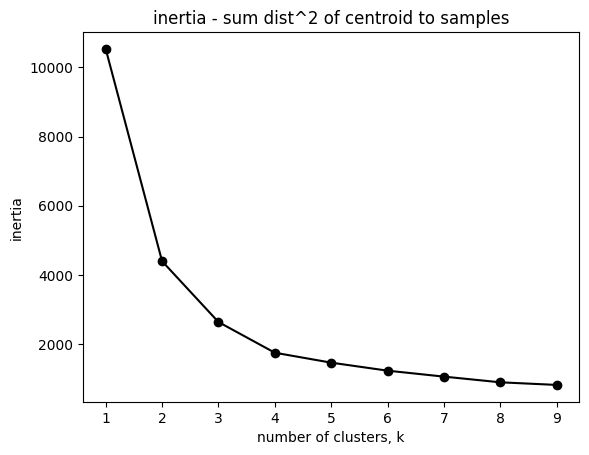

In [ ]:
# KMeans on TSNE columns, search or the elbow ?

elbow_check(TSNE_components)

## KMeans on TSNE Cluster Analysis

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

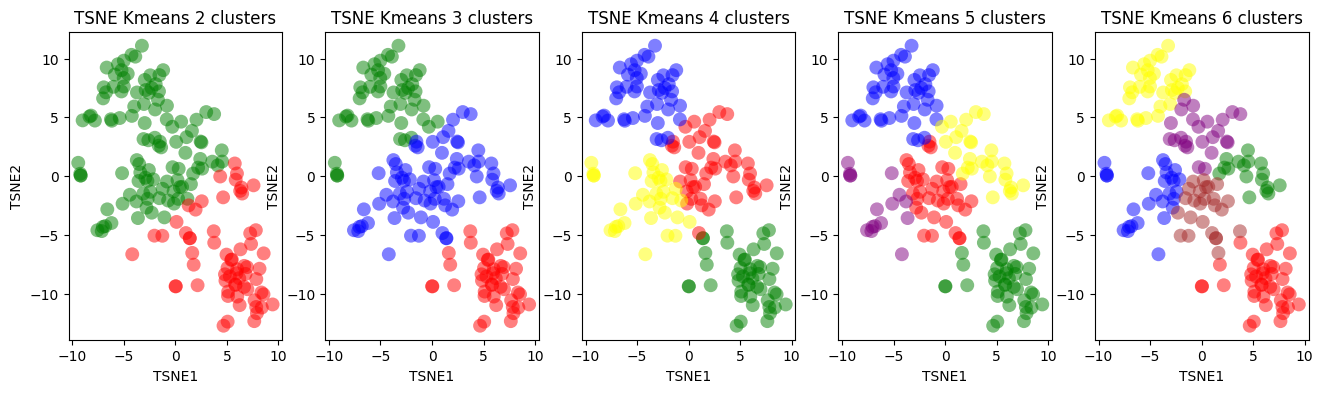

In [ ]:
cluster_cases = [2,3,4,5,6]
plot_clusters('TSNE', cluster_cases, TSNE_components)

# hmm which one to pick?

## KMeans on TSNE - Zoom with Labels

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


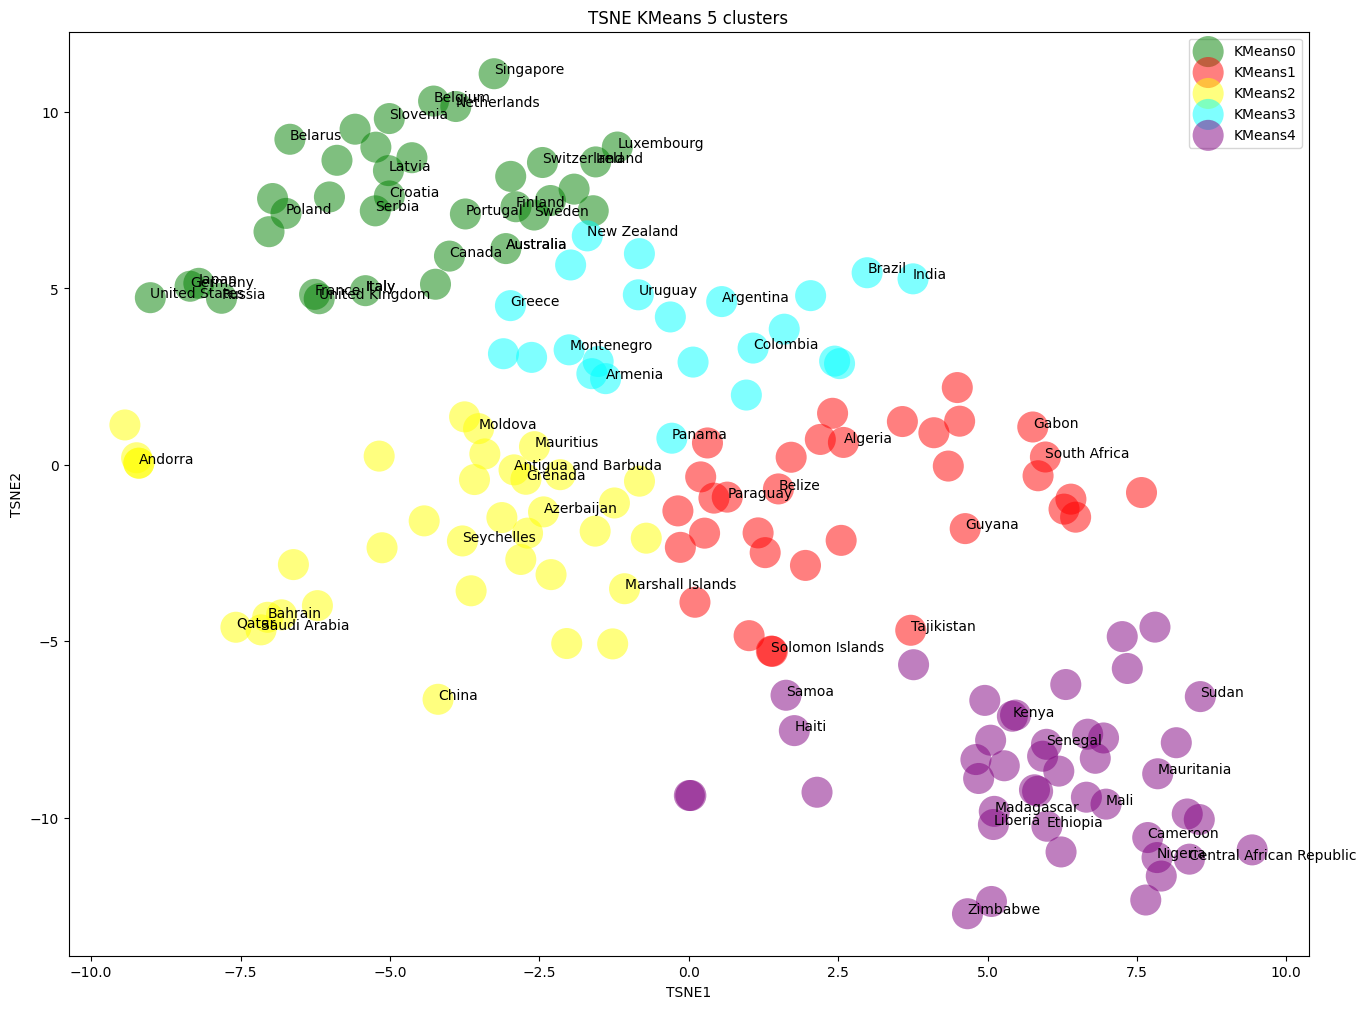

In [ ]:
# try 6 clusters -- why i dunno, looks good... 
model = KMeans(n_clusters=5)            
plot_big('KMeans','TSNE',model, TSNE_components, countries=50)

---
## DBScan on PCA Cluster Analysis


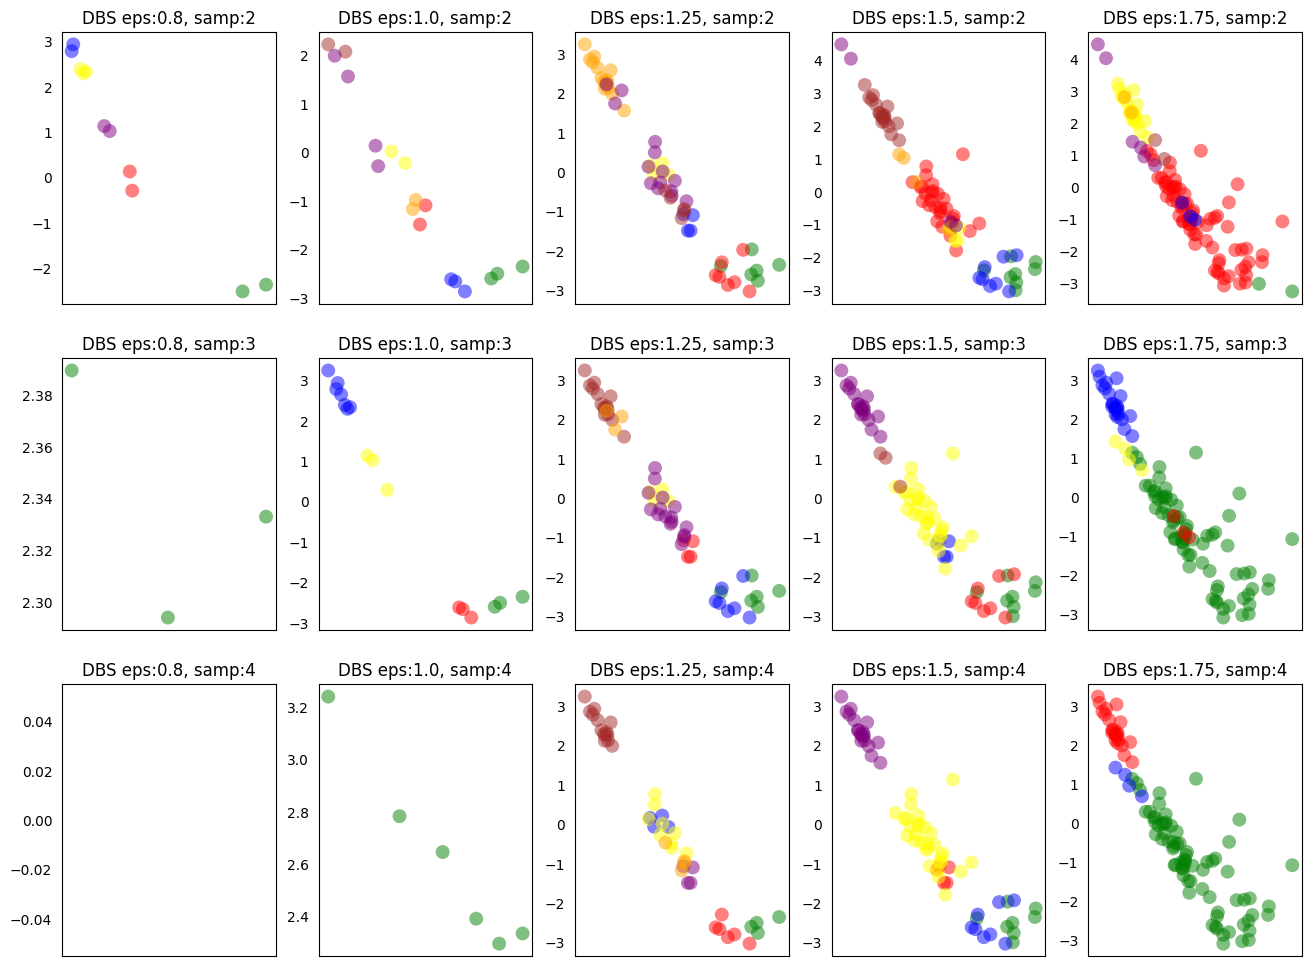

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product

# try a variety of eps & samples 
samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rl = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(16,12))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    PCA_components3 = PCA_components.copy()

    ax[k%rl][math.floor(k/rl)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(PCA_components3)
    PCA_components3.insert(0, 'cluster', clustering.labels_)

    datas = []
    for i in range(len(set(clustering.labels_))): 
#         tup = []
#         for j in range(2):  # 2d hardcoded
#             tup.append(PCA_components3[PCA_components3['cluster']==i][j])
        tup = [PCA_components3[PCA_components3['cluster']==i][j] for j in range(2)]
        datas.append(tup)

    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax[k%rl][math.floor(k/rl)].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rl][math.floor(k/rl)].set_title(f'DBS eps:{eps}, samp:{samp}')


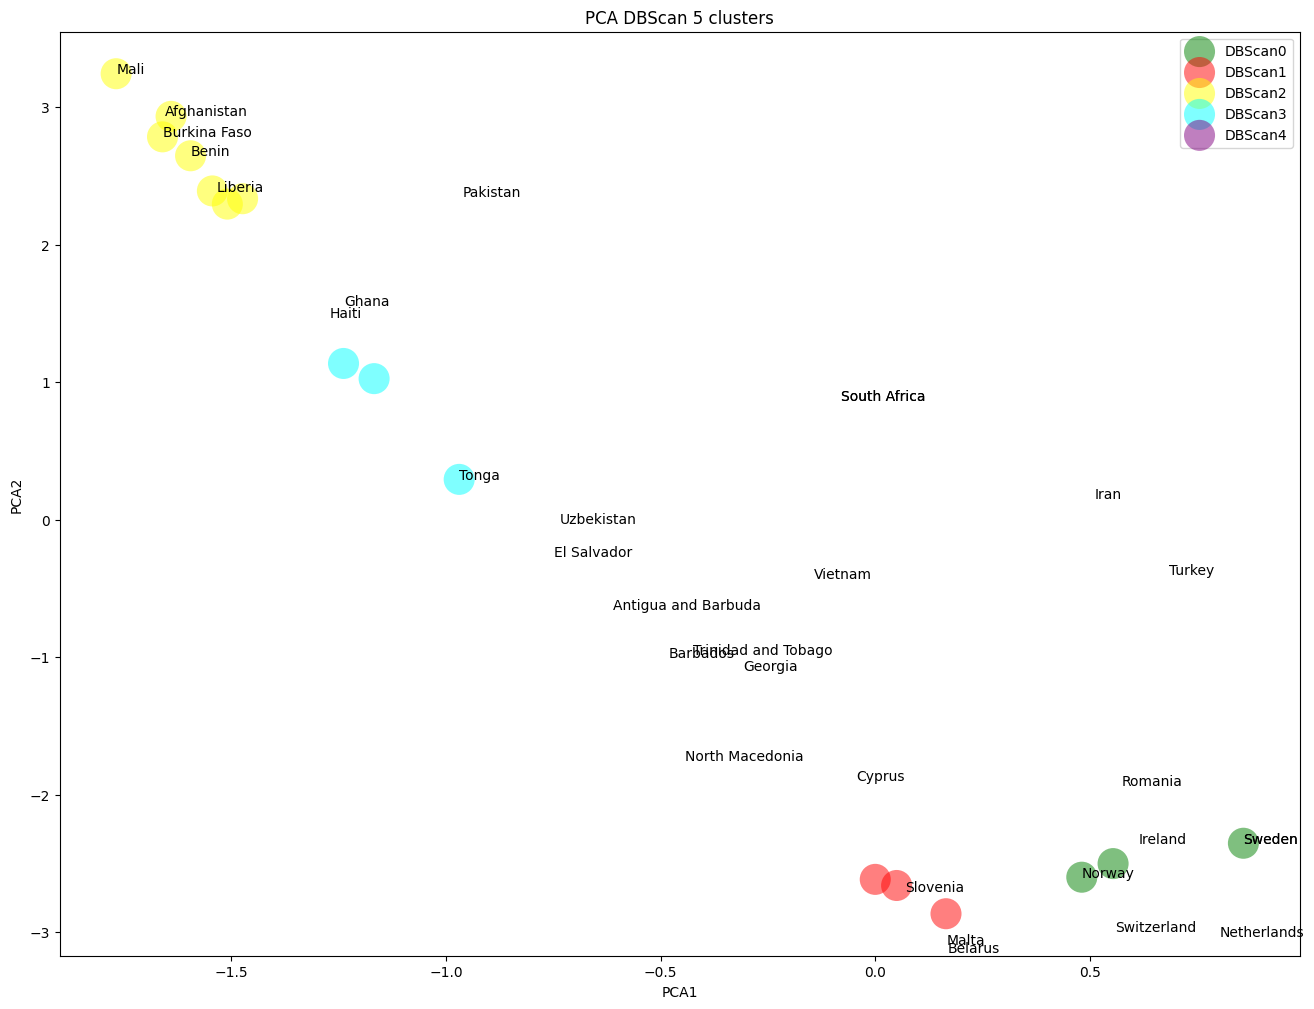

In [ ]:
PCA_components3 = PCA_components.copy()
clustering = DBSCAN(eps=1, min_samples=3).fit(PCA_components3)
plot_big('DBScan','PCA',clustering, PCA_components3) # bug w/ DBAcan use ..'


## DBScan on TSNE Cluster Analysis

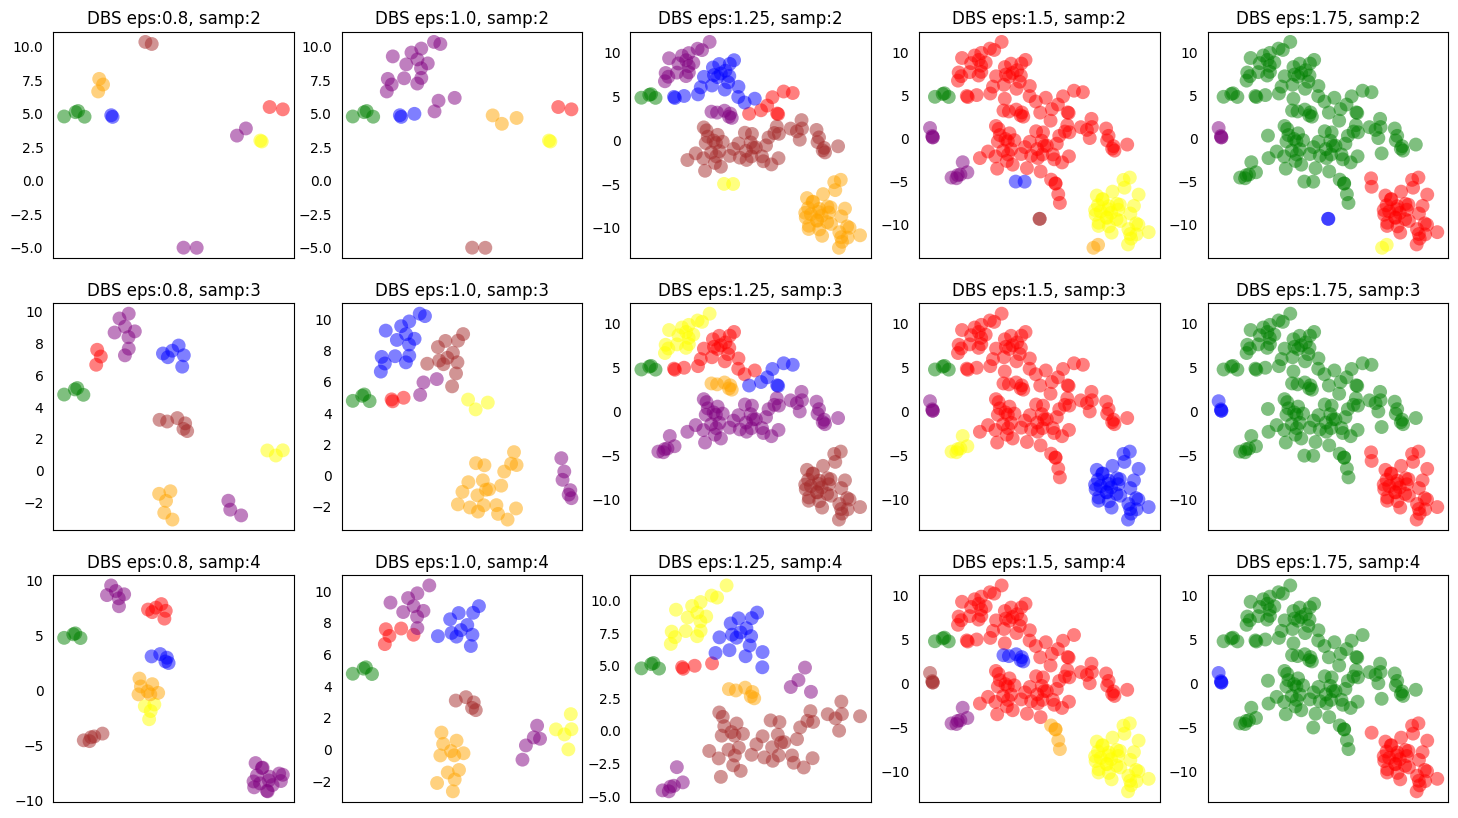

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
from itertools import product
from math import floor  

samp_list = [2,3,4]
eps_list = [0.8, 1.0, 1.25, 1.5, 1.75]
rows = len(samp_list)

fig, ax = plt.subplots(len(samp_list), len(eps_list), figsize=(18,10))

for k, (eps, samp) in enumerate(product(eps_list, samp_list)):
    ax[k%rows][floor(k/rows)].tick_params(axis='both',which='both',bottom=False,top=False,left=False,labelbottom=False) 

    TSNE_df = TSNE_components.copy()
    clustering = DBSCAN(eps=eps, min_samples=samp).fit(TSNE_df)
    TSNE_df.insert(0, 'cluster', clustering.labels_)

    datas = [[TSNE_df[TSNE_df['cluster']==i][j] for j in range(2)] for i in range(len(set(clustering.labels_)))]
    colors = ('green','red','blue','yellow','purple','brown','orange','purple')
    groups = [str(i) for i in range(len(set(clustering.labels_)))]

    for data,color,group in zip(datas,colors,groups):
        ax[k%rows][floor(k/rows)].scatter(data[0],data[1], alpha=0.5, c=color, edgecolors='none', s=100, label=group)
        ax[k%rows][floor(k/rows)].set_title(f'DBS eps:{eps}, samp:{samp}')


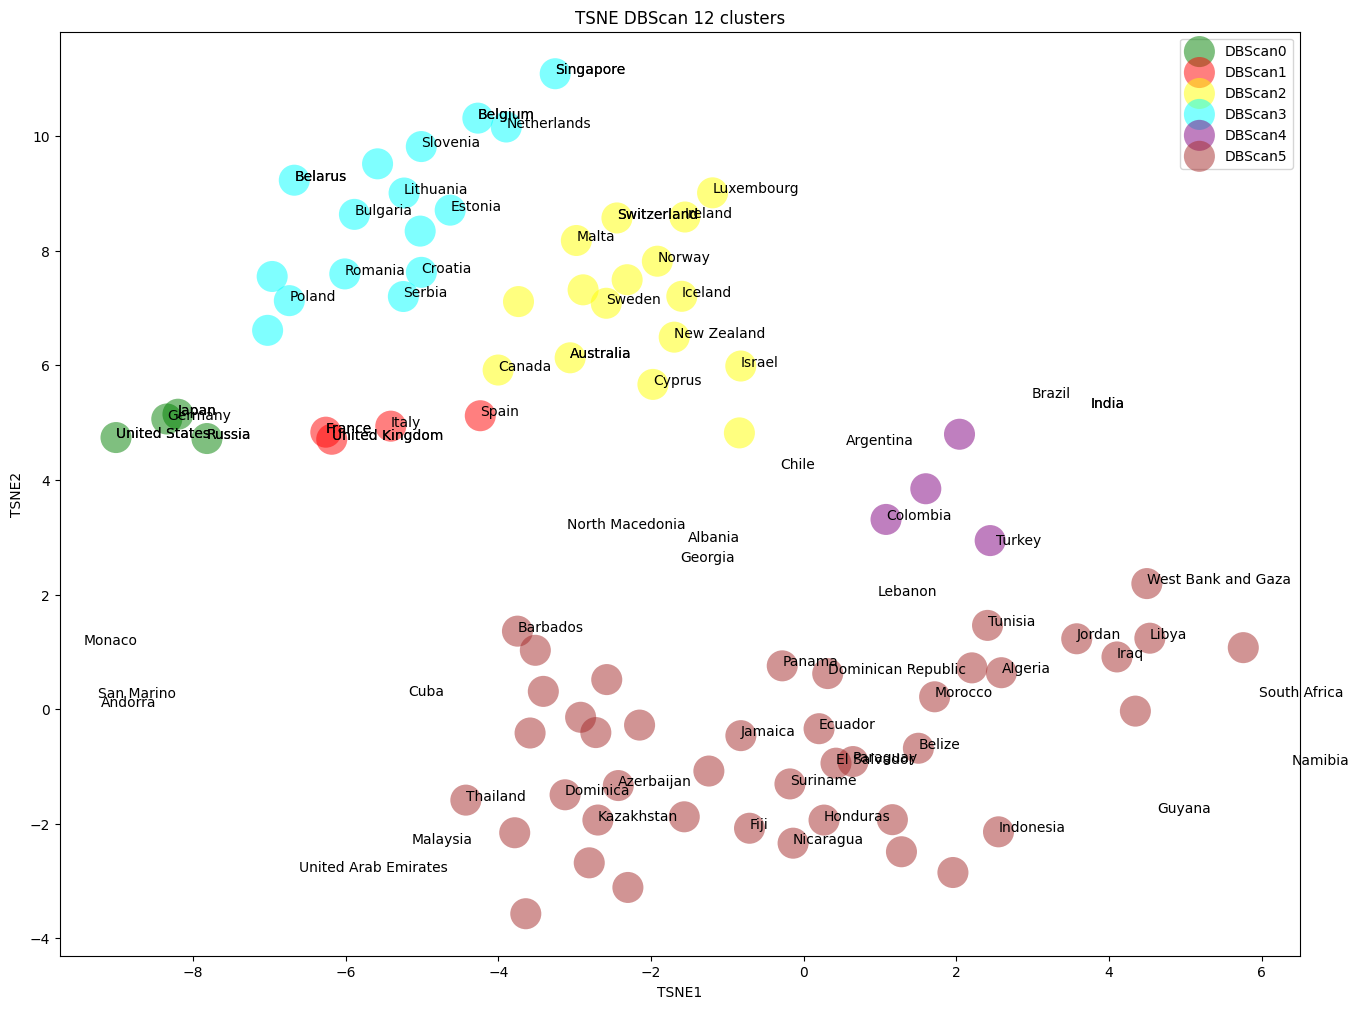

In [ ]:
TSNE_df = TSNE_components.copy()
clustering = DBSCAN(eps=1.25, min_samples=4).fit(TSNE_df)
plot_big('DBScan','TSNE',clustering, TSNE_df, countries=100)

In [ ]:
df_gmerged3.head()

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,1123836,103802702,USA,322941311,49054.333333,30420.714286,31227.928571,551.666667,311.142857,...,35.89,65094.80,55518878.0,78.79,1.81,1.71,5.30,94.0,15.79,19.69
2,India,530779,44690738,IND,1324509589,381.666667,335.714286,278.285714,1.333333,1.000000,...,465.19,6887.54,17053200.0,70.91,3.73,2.11,24.17,91.0,6.47,28.62
9,France,166176,39866718,FRA,66721256,6494.000000,4403.142857,4052.642857,20.666667,18.000000,...,123.07,50500.75,5871100.0,82.83,1.11,1.86,6.37,96.0,20.68,44.91
8,Germany,168935,38249060,DEU,82348669,12736.333333,6641.285714,11355.071429,179.333333,91.285714,...,237.82,57398.70,19596415.0,81.29,1.45,1.54,4.76,91.0,21.73,70.04
1,Brazil,699276,37076053,BRA,206163058,0.000000,1798.428571,4793.500000,0.000000,11.285714,...,25.34,15304.91,10413437.0,75.34,3.73,1.70,13.71,70.0,9.00,22.12


In [ ]:
dfc_g['Russia']
df_gmerged3[df_gmerged3['Country/Region'] == 'Russia']

,Country/Region,Deaths,Cases,Country Code,Population,Cases3dayAvg,Cases7dayAvg,Cases14dayAvg,Deaths3dayAvg,Deaths7dayAvg,...,popdensity%,GDP/cap,shipping,lifeExpYrs,inflation,fertility,COD disease,DTP immunized,pop% >= 65,trade%
3,Russia,388478,22075858,RUS,144342396,11661.0,12535.428571,12031.571429,41.0,39.571429,...,8.82,30067.74,4932154.0,73.08,4.47,1.5,3.9,97.0,14.91,39.78


In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = df_gmerged3.copy()

fig = go.Figure(data=go.Choropleth(
    locations = df['Country Code'],
    z = df['Cases'].apply(np.log),
    text = df['Country/Region'],
    colorscale = 'Reds',
#    colorscale = ['rgb(245,245,245)', 'rgb(254,224,210)', 'rgb(252,187,161)', 'rgb(252,146,114)', 'rgb(251,106,74)', 'rgb(239,59,44)', 'rgb(203,24,29)', 'rgb(165,15,21)', 'rgb(103,0,13)'],
    autocolorscale=False,
    colorbar=dict(
            title="Cases",
            titleside="top",
            tickmode="array",
            tickvals=[2, 4 ,7, 9, 11, 13],
            ticktext=["10", "100", "500", "1k",  "50k", "300k+"],
            ticks="outside"
        )))

fig.update_layout(
    title_text='Global COVID Cases',
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular' ),
    annotations = [dict(
        x=0.55, y=0.1,
        xref='paper', yref='paper',
        text='Source: <a href="https://github.com/dougfoo/machineLearning/covid"> John Hopkins + WorldBank</a>',
        showarrow = False
    )]
)

fig.show()
